# Сборный проект

## Введение

В этом учебном проекте постараемся выявить закономерности определяющие успешность игр для интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Исследование позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.  
Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. Нужно отработать принцип работы с данными.

Выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

похоже, найден оригинал данных…

[video game sales on kaggle.com](https://www.kaggle.com/datasets/gregorut/videogamesales) 🤫

<div class="alert alert-info" role="alert">
    <p class="mb-0">В коде использую <code>display()</code>, потомучто это однозначно даёт понять что планируется вывод / печать результатов. То есть использую <code>display()</code> намеренно, хотя понимаю что можно и без него выводить данные. 👌</p>
</div>

<hr>

## Шаг 0

In [2]:
import pandas as pd
import seaborn as sns
import scipy.stats as st
import numpy as np

from IPython.core.display_functions import display


In [3]:
%config InlineBackend.figure_formats = ['svg']

In [4]:
# seaborn style via MATPLOTLIBRC
custom_params = {'figure.figsize': (16, 9),
                'figure.facecolor': '#232425',
                'figure.dpi': 240,

                'legend.frameon': False,
                'legend.borderpad': 1.4,
                'legend.labelspacing': 0.7,
                'legend.handlelength': 0.7,
                'legend.handleheight': 0.7,

                'axes.facecolor': '#232425',
                'axes.labelcolor': '#EEEEEE',
                'axes.labelpad': 17,
                'axes.spines.left': False,
                'axes.spines.bottom': False,
                'axes.spines.right': False,
                'axes.spines.top': False,
                'axes.grid': False,

                'contour.linewidth': 0.0,

                'xtick.color': '#AAAAAA',
                'ytick.color': '#AAAAAA',
                'xtick.bottom': True,
                'xtick.top': False,
                'ytick.left': True,
                'ytick.right': False,

                'text.color': '#EEEEEE',
                'font.sans-serif': [
                    'Helvetica',
                    'Verdana',
                    'sans-serif'
                    ]
                }
sns.set_theme(style='darkgrid', rc=custom_params)
sns.set_context("notebook", font_scale=1.37)

<hr>

## Шаг 1. Откроем файл с данными и изучим общую информацию

Загружаем данные тестового задания.

In [5]:
try:
    games_df = pd.read_csv('./datasets/games.csv')
except FileNotFoundError:
    games_df = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
    print('games_df loaded by url')

Заменим названия столбцов (приведем к нижнему регистру);

In [6]:
games_df.columns = games_df.columns.str.lower()

In [7]:
display(
    games_df.sample(7)
)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3457,World Cup 98,N64,1998.0,Sports,0.14,0.40,0.00,0.04,NaN,NaN,NaN
6541,Drakan: The Ancients' Gates,PS2,2002.0,Adventure,0.13,0.10,0.00,0.03,78.0,9,M
15191,Ookami to Koushinryou: Omiowataru Kaze,DS,2009.0,Adventure,0.00,0.00,0.02,0.00,NaN,NaN,NaN
16052,Girl Friend Beta: Kimi to Sugosu Natsuyasumi,PSV,2015.0,Action,0.00,0.00,0.02,0.00,NaN,NaN,NaN
2576,Rayman Raving Rabbids 2,DS,2007.0,Misc,0.73,0.01,0.00,0.06,57.0,7,E10+
13499,Art of Fighting Anthology,PS2,2006.0,Fighting,0.02,0.02,0.00,0.01,60.0,7,T
3525,Wreckless: ThE YaKuza MisSiOns,XB,2002.0,Racing,0.42,0.11,0.02,0.02,74.0,5.2,T


In [8]:
display(
    games_df.info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

### Колонки с пропусками:

In [9]:
display(
    games_df.columns[games_df.isna().any()].tolist()
)

['name', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']

⭕️ 'name' `NaN`  
⭕️ 'year_of_release' `NaN`  
⭕️ 'genre' `NaN`  
⭕️ 'critic_score' `NaN`  
⭕️ 'user_score' `NaN`  
⭕️ 'rating' `NaN`  

#### `name` — название игры

In [10]:
display(
    games_df.loc[games_df['name'].isna()]
)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [11]:
games_df.dropna(axis=0, subset=['name'], inplace=True)

In [12]:
display(games_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


None

✅ ‘name’ `NaN`  
⭕️ 'year_of_release' `NaN`  
✅ 'genre' `NaN`  
⭕️ 'critic_score' `NaN`  
⭕️ 'user_score' `NaN`  
⭕️ 'rating' `NaN`  

In [13]:
display(
    games_df.loc[games_df['name'] == 'Madden NFL 13']
)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
507,Madden NFL 13,X360,2012.0,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
3986,Madden NFL 13,Wii,2012.0,Sports,0.47,0.00,0.0,0.03,NaN,7.3,E
5887,Madden NFL 13,PSV,2012.0,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E
7066,Madden NFL 13,WiiU,2012.0,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


In [14]:
display(
    len(games_df['name'].unique())
)

11559

#### `year_of_release` — год выпуска

In [15]:
display(
    games_df.groupby(
        by='year_of_release'
    )['name'].count()
)

year_of_release
1980.0       9
1981.0      46
1982.0      36
1983.0      17
1984.0      14
1985.0      14
1986.0      21
1987.0      16
1988.0      15
1989.0      17
1990.0      16
1991.0      41
1992.0      43
1993.0      60
1994.0     121
1995.0     219
1996.0     263
1997.0     289
1998.0     379
1999.0     338
2000.0     350
2001.0     482
2002.0     829
2003.0     775
2004.0     762
2005.0     939
2006.0    1006
2007.0    1197
2008.0    1427
2009.0    1426
2010.0    1255
2011.0    1136
2012.0     653
2013.0     544
2014.0     581
2015.0     606
2016.0     502
Name: name, dtype: int64

Заменим `NaN` на `1970`, в расчётах не будем учитывать)

In [16]:
games_df[
        'year_of_release'
    ].fillna(
        value=1970,
        inplace=True
    )

✅ ‘name’ `NaN`  
✅ 'year_of_release' `NaN`  
⭕️ 'genre' `NaN`  
⭕️ 'critic_score' `NaN`  
⭕️ 'user_score' `NaN`  
⭕️ 'rating' `NaN`

#### `genre` — жанр игры

In [17]:
display(
    games_df['genre'].unique(),
    games_df.loc[
        games_df['genre'].isna()
    ]['name'].count()
)

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

0

#### `critic_score` — оценка критиков (максимум 100)

In [18]:
display(
    games_df['critic_score'].describe()
)

count    8137.000000
mean       68.967679
std        13.938165
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

In [19]:
display('Количество продаж игр, у которых пропущена оценка критиков',
    games_df.loc[
        games_df['critic_score'].isna()
        , ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
    ].describe(),
    'Количество продаж игр, у которых известна оценка критиков',
    games_df.loc[
        games_df['critic_score'].notna()
        , ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
    ].describe()
)

'Количество продаж игр, у которых пропущена оценка критиков'

,na_sales,eu_sales,jp_sales,other_sales
count,8576.000000,8576.000000,8576.000000,8576.000000
mean,0.178215,0.085017,0.099065,0.023535
std,0.715940,0.321036,0.343974,0.088748
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.020000,0.000000,0.000000,0.000000
75%,0.140000,0.050000,0.060000,0.020000
max,29.080000,10.950000,10.220000,2.740000


'Количество продаж игр, у которых известна оценка критиков'

,na_sales,eu_sales,jp_sales,other_sales
count,8137.000000,8137.000000,8137.000000,8137.000000
mean,0.352980,0.208311,0.055028,0.072435
std,0.896476,0.635622,0.265075,0.249204
min,0.000000,0.000000,0.000000,0.000000
25%,0.050000,0.010000,0.000000,0.010000
50%,0.130000,0.050000,0.000000,0.020000
75%,0.340000,0.180000,0.010000,0.060000
max,41.360000,28.960000,6.500000,10.570000


Заменим `NaN` на `-1`, то есть значение пропущенно.

In [20]:
games_df[
        'critic_score'
    ].fillna(
    value=-1,
    inplace=True
)

✅ ‘name’ `NaN`  
✅ 'year_of_release' `NaN`  
✅ 'genre' `NaN`  
✅ 'critic_score' `NaN`  
⭕️ 'user_score' `NaN`  
⭕️ 'rating' `NaN`

#### `user_score` — оценка пользователей (максимум 10)

In [21]:
display(
    games_df['user_score'].describe()
)

count     10014
unique       96
top         tbd
freq       2424
Name: user_score, dtype: object

**tbd — To Be Determined.**
В интернетах пишут, что `'tbd'` обозначают оценки у которых недостаточно проголосовавших. То есть например игру оценили менее 4 игроков.

Заменим `'tbd'` на `13`, потомучто оценка не можеть быть больше **10**.

In [22]:
games_df['user_score'].replace(
    to_replace='tbd',
    value=13,
    inplace=True
)

Заменим `NaN` на `-1`, то есть значение пропущенно.

In [23]:
games_df['user_score'].fillna(
    value=-1,
    inplace=True
)

In [24]:
display(
    games_df['user_score'].describe()
)

count     16713
unique       97
top          -1
freq       6699
Name: user_score, dtype: int64

✅ ‘name’ `NaN`  
✅ 'year_of_release' `NaN`  
✅ 'genre' `NaN`  
✅ 'critic_score' `NaN`  
✅ 'user_score' `NaN`  
⭕️ 'rating' `NaN`

#### `rating` — рейтинг от организации ESRB

(англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [25]:
display(
    games_df.loc[
        games_df['rating'].isna(),
        'name'
    ].count()
)

6764

In [26]:
display(
    games_df.loc[
        games_df['rating'].notna(),
            'rating'
    ].unique()
)

array(['E', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

- ` E ` — Everyone → 1994–1998 (as K-A), 1998–present (as E)
- ` M ` — Mature 17+ → 1994–present
- ` T ` — Teen → 1994–present
- ` E10+ ` — Everyone 10+ → 2005–present
- ` K-A ` — Everyone → 1994–1998
- ` A-0 ` — Adults Only 18+ → 1994–present
- ` EC ` — Early Childhood → 1994–2018
- ` RP ` — Rating Pending → 1994–present
- ` no_ESRB ` — without ESRB

In [27]:
games_df['rating'].fillna(
    value='no_ESRB',
    inplace=True
)

In [28]:
display(
    games_df.loc[
        games_df['rating'].isna()
        , 'name'
    ].count()
)

0

✅️ ‘name’ `NaN`  
✅️ 'year_of_release' `NaN`  
✅️ 'genre' `NaN`  
✅️ 'critic_score' `NaN`  
✅️ 'user_score' `NaN`  
✅️ 'rating' `NaN`

### Посмотрим на остальные колонки:

#### `platform` — платформа

In [29]:
display(
    sorted(games_df['platform'].unique()),
    len(games_df['platform'].unique()),
)

['2600',
 '3DO',
 '3DS',
 'DC',
 'DS',
 'GB',
 'GBA',
 'GC',
 'GEN',
 'GG',
 'N64',
 'NES',
 'NG',
 'PC',
 'PCFX',
 'PS',
 'PS2',
 'PS3',
 'PS4',
 'PSP',
 'PSV',
 'SAT',
 'SCD',
 'SNES',
 'TG16',
 'WS',
 'Wii',
 'WiiU',
 'X360',
 'XB',
 'XOne']

31

#### `na_sales` — продажи в Северной Америке (миллионы проданных копий)

In [30]:
display(
    games_df['na_sales'].describe(),
    games_df.loc[games_df['na_sales'] > 4]
)

count    16713.000000
mean         0.263302
std          0.813565
min          0.000000
25%          0.000000
50%          0.080000
75%          0.240000
max         41.360000
Name: na_sales, dtype: float64

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,-1.0,-1,no_ESRB
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1,no_ESRB
...,...,...,...,...,...,...,...,...,...,...,...
145,Sonic the Hedgehog 2,GEN,1992.0,Platform,4.47,1.20,0.16,0.19,-1.0,-1,no_ESRB
183,Madden NFL 2004,PS2,1970.0,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
238,Madden NFL 2005,PS2,2004.0,Sports,4.18,0.26,0.01,0.08,91.0,7.9,E
240,Pitfall!,2600,1981.0,Platform,4.21,0.24,0.00,0.05,-1.0,-1,no_ESRB


#### `eu_sales` — продажи в Европе (миллионы проданных копий)

In [31]:
display(
    games_df['eu_sales'].describe()
)

count    16713.000000
mean         0.145045
std          0.503359
min          0.000000
25%          0.000000
50%          0.020000
75%          0.110000
max         28.960000
Name: eu_sales, dtype: float64

#### `jp_sales` — продажи в Японии (миллионы проданных копий)

In [32]:
display(
    games_df['jp_sales'].describe()
)

count    16713.000000
mean         0.077625
std          0.308871
min          0.000000
25%          0.000000
50%          0.000000
75%          0.040000
max         10.220000
Name: jp_sales, dtype: float64

#### `other_sales` — продажи в других странах (миллионы проданных копий)

In [33]:
display(
    games_df['other_sales'].describe()
)

count    16713.000000
mean         0.047343
std          0.186742
min          0.000000
25%          0.000000
50%          0.010000
75%          0.030000
max         10.570000
Name: other_sales, dtype: float64

<hr>

## Шаг 2. Подготовьте данные

### Преобразуем данные в подходящие и достаточные типы данных.

Чтобы снизить количество памяти, которое занимает DataFrame.

In [34]:
games_df = games_df.astype(
    {
        # 'name': '',
        'platform': 'category',
        'year_of_release': 'uint16',
        'genre': 'category',
        'na_sales': 'float16',
        'eu_sales': 'float16',
        'jp_sales': 'float16',
        'other_sales': 'float16',
        'critic_score': 'int8',
        'user_score': 'float16',
        'rating': 'category',
    }
)

In [35]:
display(
    games_df.info()
 )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16713 non-null  object  
 1   platform         16713 non-null  category
 2   year_of_release  16713 non-null  uint16  
 3   genre            16713 non-null  category
 4   na_sales         16713 non-null  float16 
 5   eu_sales         16713 non-null  float16 
 6   jp_sales         16713 non-null  float16 
 7   other_sales      16713 non-null  float16 
 8   critic_score     16713 non-null  int8    
 9   user_score       16713 non-null  float16 
 10  rating           16713 non-null  category
dtypes: category(3), float16(5), int8(1), object(1), uint16(1)
memory usage: 524.3+ KB


None

Присвоили надлежащие типы данных и теперь DataFrame использует в памяти 0.5 Mb вместо 1.4 Mb.

<hr>

Посчитаем суммарное количество продаж во всех регионах и запишем их в отдельный столбец.

In [36]:
games_df['sum_sales'] = games_df.loc[
    : ,
    ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
].sum(axis=1)

In [37]:
display(
    games_df.sample(5)
)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
8887,Cardinal Syn,PS,1998,Fighting,0.080017,0.059998,0.000000,0.010002,-1,-1.000000,no_ESRB,0.150024
1105,LEGO Batman 2: DC Super Heroes,X360,2012,Action,0.899902,0.609863,0.000000,0.150024,79,7.199219,E10+,1.660156
13334,ESPN Great Outdoor Games Bass 2002,GBA,2001,Sports,0.029999,0.010002,0.000000,0.000000,57,13.000000,E,0.040009
939,Chrono Cross,PS,1999,Role-Playing,0.620117,0.419922,0.689941,0.119995,94,8.101562,T,1.850586
5636,SpongeBob SquarePants: Double Pack,GBA,2005,Platform,0.229980,0.080017,0.000000,0.010002,-1,-1.000000,no_ESRB,0.320068


<hr>

## Шаг 3. Исследуем данные

In [38]:
with_years = games_df['year_of_release'] != 1970

In [39]:
with_users_score = games_df['user_score'] != -1

In [40]:
with_users_score_value = (
    (games_df['user_score'] != -1)
    & (games_df['user_score'] != 13)
)

In [41]:
with_critics_score = games_df['critic_score'] != -1

In [42]:
with_rating = games_df['rating'] != 'no_ESRB'

In [43]:
start_year = 1990

In [44]:
analytic_start_year = 2012

In [45]:
years_analytics = (
    with_years
    & (games_df['year_of_release'] >= analytic_start_year)
)

### Сколько игр выпускалось в разные годы.

In [47]:
games_by_years = games_df.loc[
    years_analytics,
    ['year_of_release',
     'name',
     'platform']
]

In [49]:
display(
    games_by_years.sample(5)
)

,year_of_release,name,platform
16312,2015,Monster High: New Ghoul in School,Wii
1012,2015,The Elder Scrolls Online,PS4
15934,2016,New Interpretation Stranger of Sword City,PSV
13011,2015,Luminous Arc Infinity,PSV
12891,2016,Hearts of Iron IV,PC


[Text(0.5, 1.0, 'количество выпущенных игр'),
 Text(0.5, 0, 'год'),
 Text(0, 0.5, 'количество')]

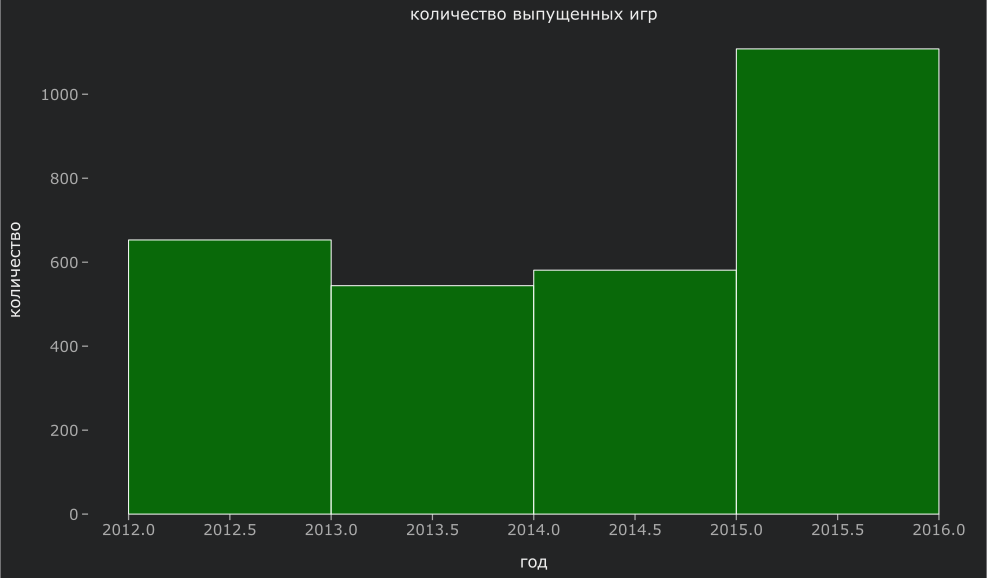

In [ ]:
sns.histplot(
    data=games_by_years,
    x='year_of_release',
    # hue='platform',
    binwidth=1,
    color='green'
    # bins=len(games_by_years),
).set(
    title='количество выпущенных игр',
    xlabel='год',
    ylabel='количество'
)

In [54]:
platforms_by_years = games_df.loc[
    years_analytics,
    ['year_of_release',
     'platform']
]

platforms_by_years = platforms_by_years.groupby(
        by='year_of_release'
    )['platform'].nunique()

platforms_by_years = platforms_by_years.reset_index()
# display(platforms_by_years)

[Text(0.5, 1.0, 'количество платформ'),
 Text(0.5, 0, 'год'),
 Text(0, 0.5, 'количество')]

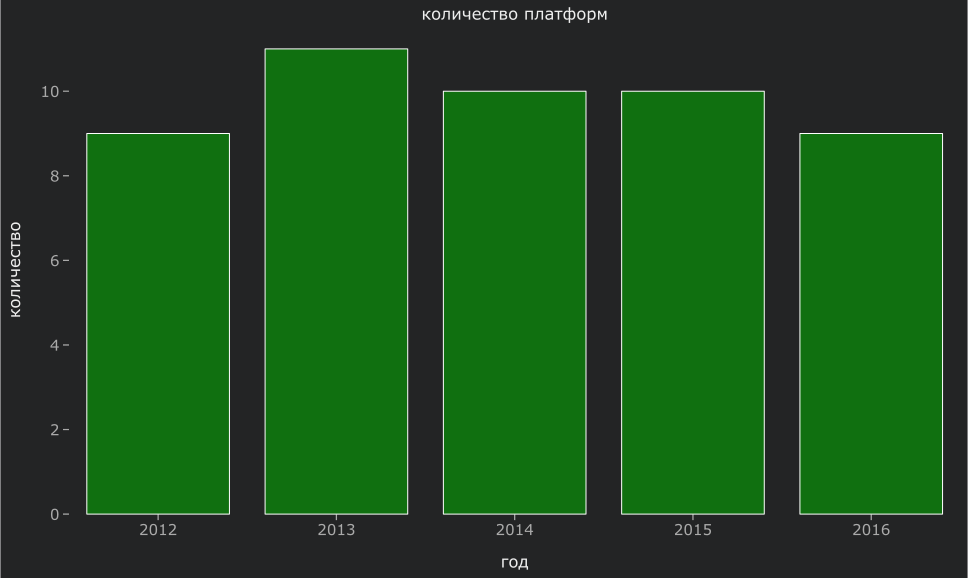

In [55]:
sns.barplot(
    data=platforms_by_years,
    x='year_of_release',
    y='platform',
    hue=None,
    color='green',
    # binwidth=1,
).set(
    title='количество платформ',
    xlabel='год',
    ylabel='количество',
)

# .set_xticklabels(labels=[1990, 1995, 2000, 2005, 2010, 2015], rotation=30)

 Важны ли данные за все периоды?

In [56]:
def count_platform(year):
    platform_list = list(
        games_df.loc[
            games_df['year_of_release'] >= year,
            'platform'
        ].unique()
    )

    return platform_list

Платформы начиная с 1990

In [57]:
year_90 = 1990
print(f'Количество платформ начиная с {year_90} г = {len(count_platform(year_90))}')

Количество платформ начиная с 1990 г = 30


Платформы начиная с 1995

In [58]:
year_95 = 1995
print(f'Количество платформ начиная с {year_95} г =  {len(count_platform(year_95))}')

Количество платформ начиная с 1995 г =  26


Платформы начиная с 2000

In [59]:
year_00 = 2000
print(f'Количество платформ начиная с {year_00} г = {len(count_platform(year_00))}')

Количество платформ начиная с 2000 г = 20


Платформы начиная с 2005

In [60]:
year_05 = 2005
print(f'Количество платформ начиная с {year_05} г = {len(count_platform(year_05))}')

Количество платформ начиная с 2005 г = 16


Платформы начиная с 2010

In [61]:
year_10 = 2010
print(f'Количество платформ начиная с {year_10} г = {len(count_platform(year_10))}')

Количество платформ начиная с 2010 г = 12


Платформы начиная с 2015

In [62]:
year_15 = 2015
print(f'Количество платформ начиная с {year_15} г = {len(count_platform(year_15))}')

Количество платформ начиная с 2015 г = 10


In [63]:
platform_90 = list(games_by_years['platform'].unique())


In [64]:
display(
    sorted(games_df.loc[
        games_df['year_of_release'] < start_year,
        'platform'
    ].unique())
)

['2600',
 '3DS',
 'DS',
 'GB',
 'GBA',
 'GC',
 'N64',
 'NES',
 'PC',
 'PS',
 'PS2',
 'PS3',
 'PSP',
 'PSV',
 'Wii',
 'X360',
 'XB']

### Актуальный период

Актуальный период возьмём с 2012.  
Потомучто время жизни платформы 7~10 лет. То есть пик популярности примерно в середине этого периода. Значит имеет смысл смотреть данные за последние 4 года, чтобы понять на какую платформу и жанры делать ставку…

### Как менялись продажи по платформам.

Выбирем латформы с наибольшими суммарными продажами и построим распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [65]:
platforms_releases = games_df.loc[
        years_analytics,
        ['year_of_release', 'platform', 'name']
    ]

In [68]:
games_to_heatmap = platforms_releases.groupby(
    by=['platform', 'year_of_release']
)[['name']].count()

games_to_heatmap = games_to_heatmap.reset_index()
games_to_heatmap = games_to_heatmap.pivot(
    index='platform',
    columns='year_of_release',
    values='name'
)

[Text(0.5, 1.0, 'количество игр для платформ'),
 Text(0.5, 133.66666666666669, 'год'),
 Text(343.66666666666663, 0.5, 'платформы')]

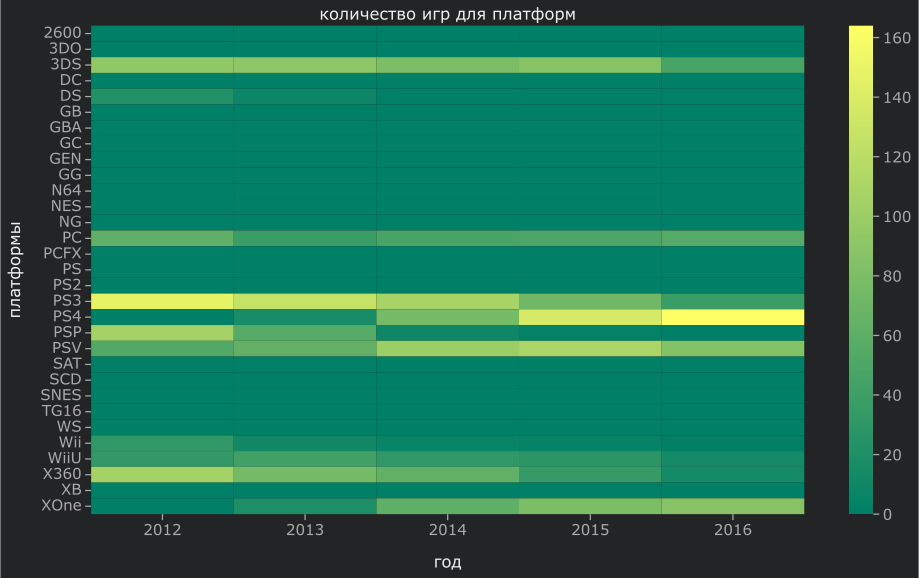

In [69]:
sns.heatmap(
    data=games_to_heatmap,
    cmap='summer',
).set(
    title='количество игр для платформ',
    xlabel='год',
    ylabel='платформы',
)

На графике видно что платформы популярны среди GameDev компаний от 7-10 лет. Очень похоже что это цыкл жизни платформы. С 1990 до 2000 всплесков по платформам 4-6. С 1995 платформа PS и N64 были популярны. А вот с 2000 количество игр для разных платформ увеличилось значительно. Можно заметить что PC не самая популярная, но «долгоиграющая» платформа.
Таким обазом потенциальные платформы для разработки лучше выбирать из тех что популярны и прибыльны с 2012 по 2016, так в 2017 платформа будет на пике популярности.

### Какие платформы лидируют по продажам, растут или падают?

In [70]:
platforms_sales = games_df.loc[
    with_years
    & (games_df['year_of_release'] >= analytic_start_year),
    ['year_of_release', 'platform', 'sum_sales']
]

In [72]:
sales_to_heatmap = platforms_sales.groupby(
    by=['platform', 'year_of_release']
)[['sum_sales']].sum()

In [73]:
# display(
#     sales_to_heatmap.sort_values(
#         by='sum_sales',
#         ascending=False
#     ).iloc[0: 47]
# )

In [74]:
sales_to_heatmap = sales_to_heatmap.reset_index()
sales_to_heatmap = sales_to_heatmap.pivot(
    index='platform',
    columns='year_of_release',
    values='sum_sales'
)

[Text(0.5, 1.0, 'сумма продаж игр для платформ'),
 Text(0.5, 133.66666666666669, 'год'),
 Text(343.66666666666663, 0.5, 'платформы')]

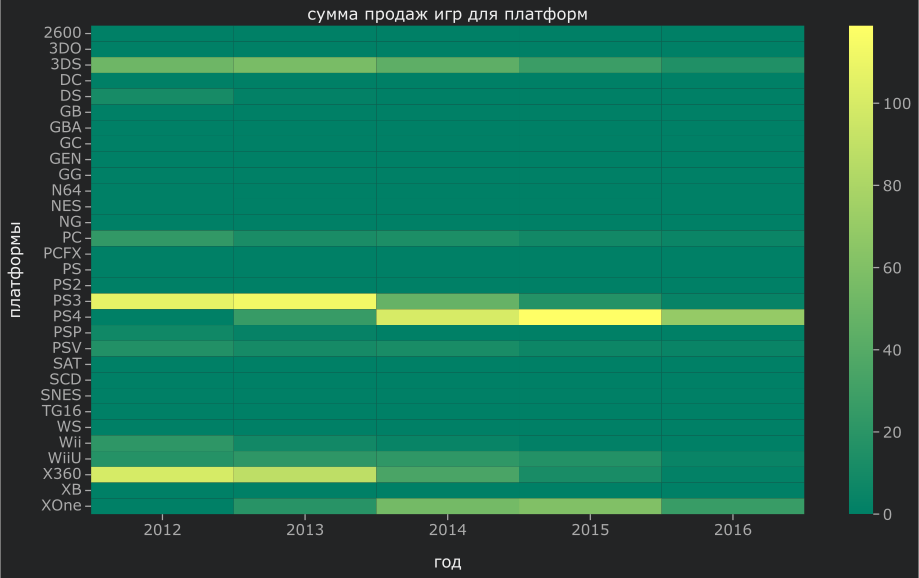

In [75]:
sns.heatmap(
    data=sales_to_heatmap,
    cmap='summer',
).set(
    title='сумма продаж игр для платформ',
    xlabel='год',
    ylabel='платформы',
)

 Выбераем несколько потенциально прибыльных платформ.

Для каких платформ сделаи большенство игр с 2012 по 2016:
- XOne
- X360
- WiiU
- PSP
- PS4
- PS3
- PS
- 3DS

Для каких платформ продали больше копий с 2012 по 2016:
- XOne
- X360
- WiiU
- PSV
- PS4
- PS3
- PS
- 3DS

В итоге можно сделать ставку на:
- XOne
- PS4
- PC
- 3DS

<hr>

### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.


In [76]:
def plot_by_year(year):
    list_of_sales = games_df.loc[
        (games_df['year_of_release'] == year)
        & (games_df['sum_sales'] > 0.5),
        ['sum_sales', 'platform']
    ]
    plot_return = sns.boxplot(
        data=list_of_sales,
        x='sum_sales',
        y='platform',
    ).set(
        title=f'сумма продаж игр для платформ в {year} г',
        xlabel='млн копий',
        ylabel='платформы',
    )
    return plot_return


Через функцию строит только крайнее значение. 🤷‍♂️

[Text(0.5, 1.0, 'сумма продаж игр для платформ в 2012 г'),
 Text(0.5, 0, 'млн копий'),
 Text(0, 0.5, 'платформы')]

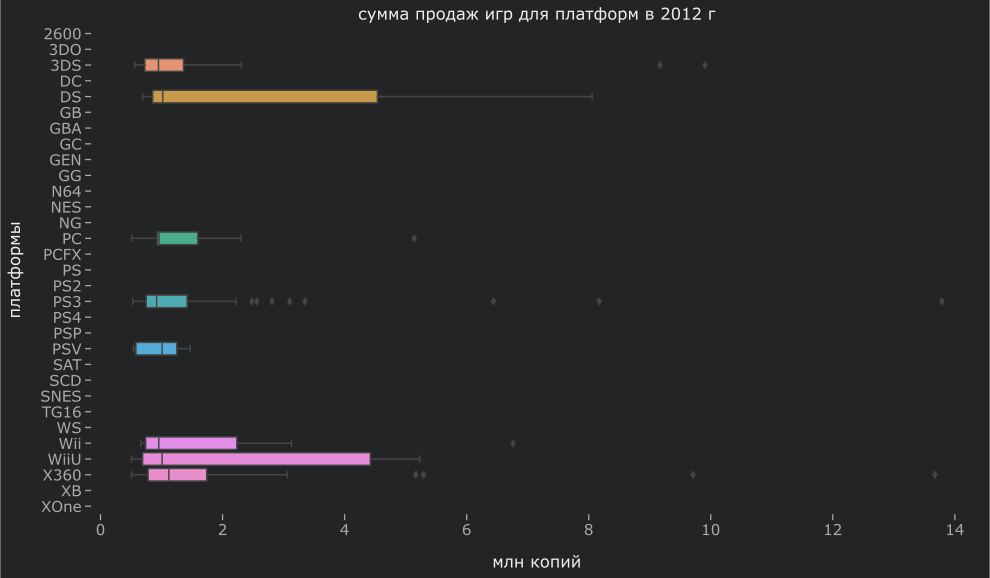

In [77]:
plot_by_year(analytic_start_year)

[Text(0.5, 1.0, 'сумма продаж игр для платформ в 2013 г'),
 Text(0.5, 0, 'млн копий'),
 Text(0, 0.5, 'платформы')]

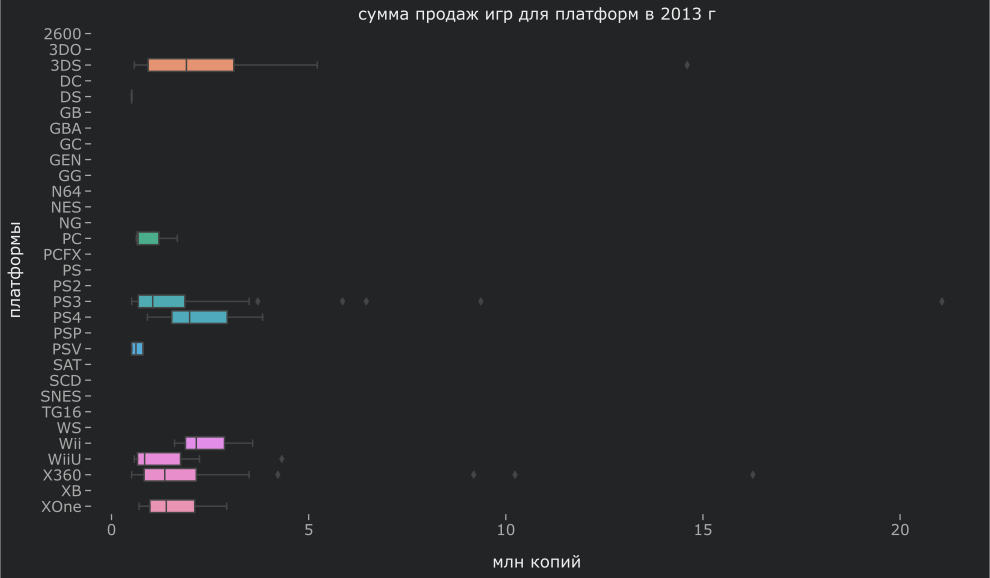

In [78]:
plot_by_year(2013)

[Text(0.5, 1.0, 'сумма продаж игр для платформ в 2014 г'),
 Text(0.5, 0, 'млн копий'),
 Text(0, 0.5, 'платформы')]

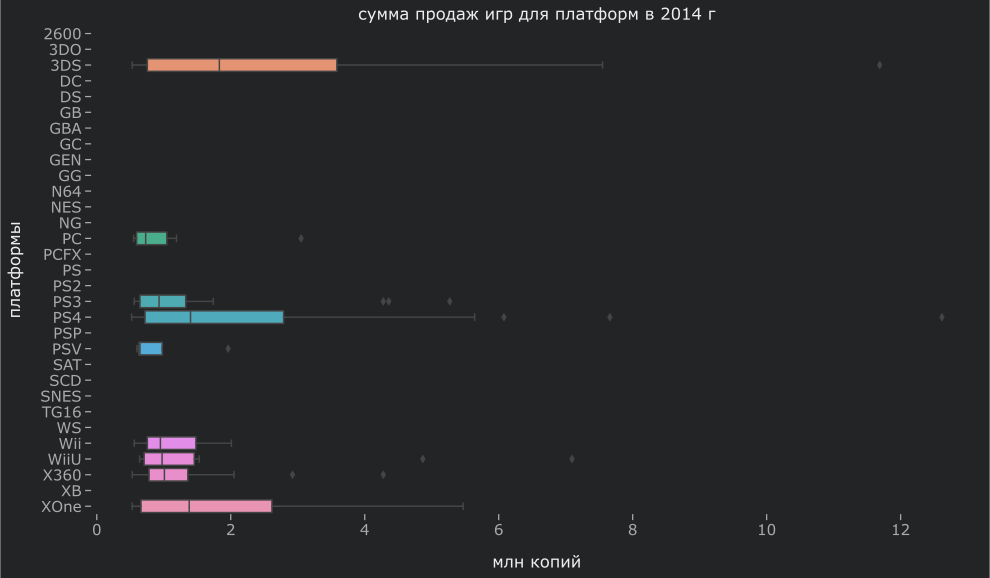

In [79]:
plot_by_year(2014)

[Text(0.5, 1.0, 'сумма продаж игр для платформ в 2015 г'),
 Text(0.5, 0, 'млн копий'),
 Text(0, 0.5, 'платформы')]

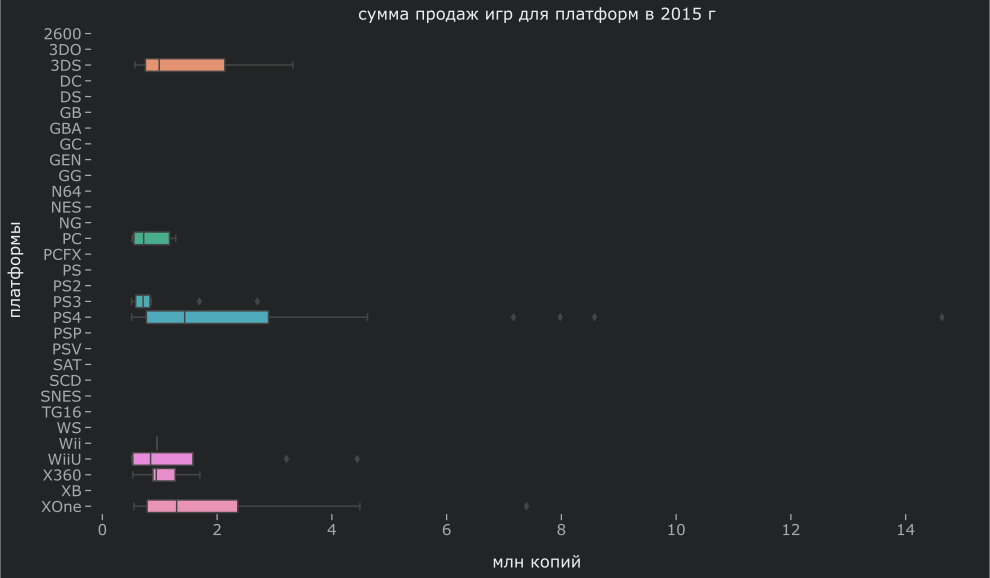

In [80]:
plot_by_year(2015)

[Text(0.5, 1.0, 'сумма продаж игр для платформ в 2016 г'),
 Text(0.5, 0, 'млн копий'),
 Text(0, 0.5, 'платформы')]

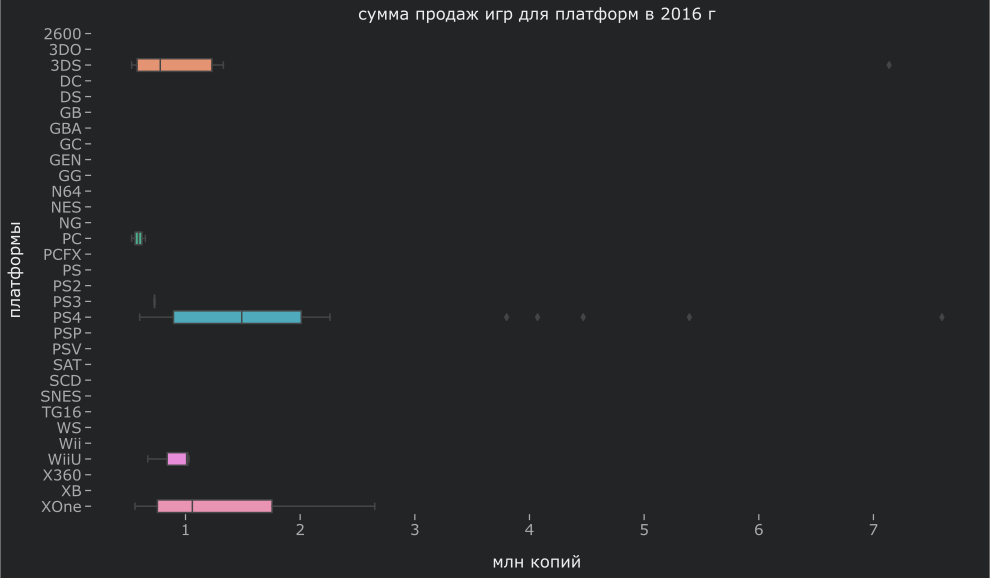

In [81]:
plot_by_year(2016)

<hr>

### Как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.


In [82]:
ps4_review_sales = games_df.loc[
    (games_df['year_of_release'] >= analytic_start_year)
    & (games_df['user_score'] != -1)
    & (games_df['user_score'] != 13)
    & (games_df['critic_score'] != -1)
    & (games_df['platform'] == 'PS4'),
    ['sum_sales', 'user_score', 'critic_score']
]

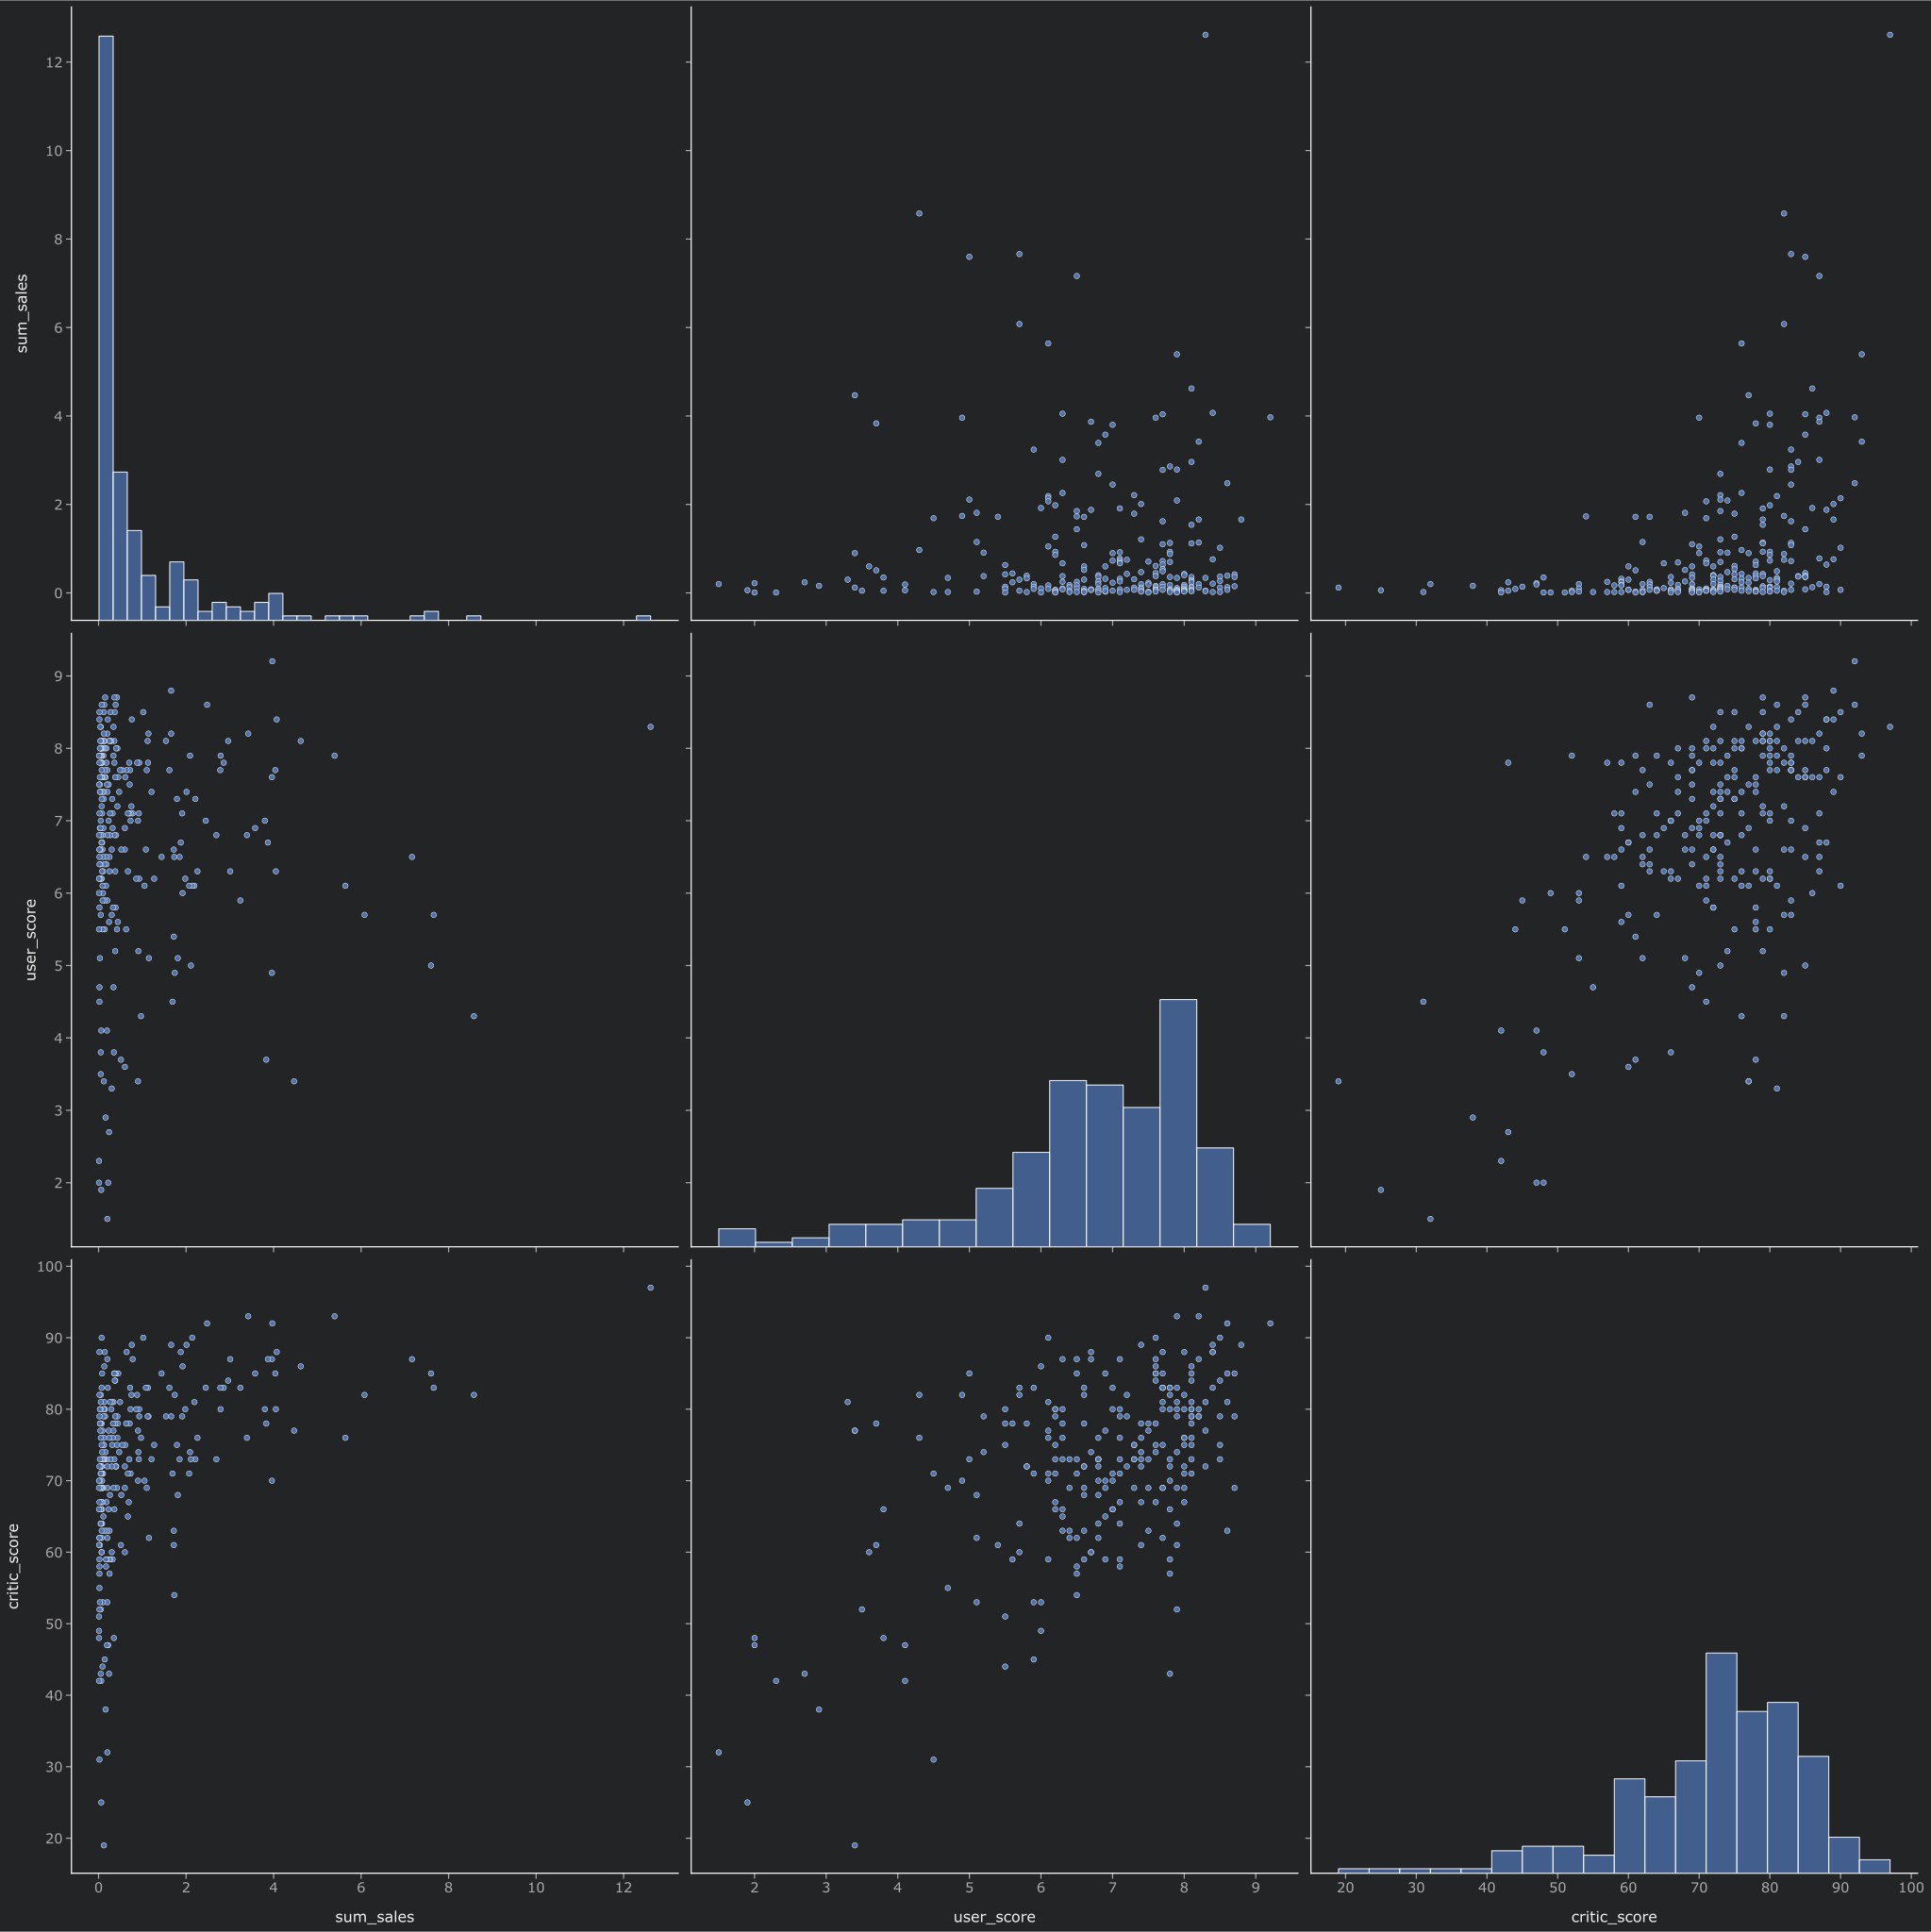

In [83]:
sns.pairplot(data=ps4_review_sales,
             height=10,
             aspect=1,
             )

 Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

In [85]:
display(
    ps4_review_sales.corr()
)

,sum_sales,user_score,critic_score
sum_sales,1.000000,-0.033673,0.405907
user_score,-0.033673,1.000000,0.557659
critic_score,0.405907,0.557659,1.000000


Присутствует положительная слабая корреляция 0.41 оценки критиков и суммы продаж.
Практически отсутствует корреляция между суммой продаж и отзывами пользователей. Что интересно, знак «–».
Умеренная корреляция 0.56 между оценками критиков и пользователей, то есть можно предположить что в целом и общем критики и пользователи сходятся во мнении)

А как с продажами игр на других платформах?


In [86]:
other_review_sales = games_df.loc[
    (games_df['year_of_release'] >= analytic_start_year)
    & (games_df['user_score'] != -1)
    & (games_df['user_score'] != 13)
    & (games_df['critic_score'] != -1)
    & (games_df['platform'] != 'PS4'),
    ['sum_sales', 'user_score', 'critic_score']
]

In [88]:
display(
    other_review_sales.corr()
)

,sum_sales,user_score,critic_score
sum_sales,1.000000,0.009803,0.282799
user_score,0.009803,1.000000,0.508458
critic_score,0.282799,0.508458,1.000000


### Общее распределение игр по жанрам.

In [89]:
games_genre = games_df.loc[
    with_years
    & (games_df['year_of_release'] >= analytic_start_year),
    ['sum_sales', 'genre']
]

In [90]:
games_genre = games_genre.groupby(by='genre').mean()
games_genre.reset_index(inplace=True)
games_genre.sort_values(by='sum_sales', ascending=False, inplace=True)

In [92]:
display(
    games_genre
)

,genre,sum_sales
8,Shooter,1.296875
4,Platform,0.717773
10,Sports,0.675781
7,Role-Playing,0.520996
6,Racing,0.465332
3,Misc,0.442871
9,Simulation,0.438965
0,Action,0.427979
2,Fighting,0.408203
11,Strategy,0.187866


[Text(0.5, 1.0, 'медиана проданных копий игр с 2012 г'),
 Text(0.5, 0, 'жанры'),
 Text(0, 0.5, 'млн копий')]

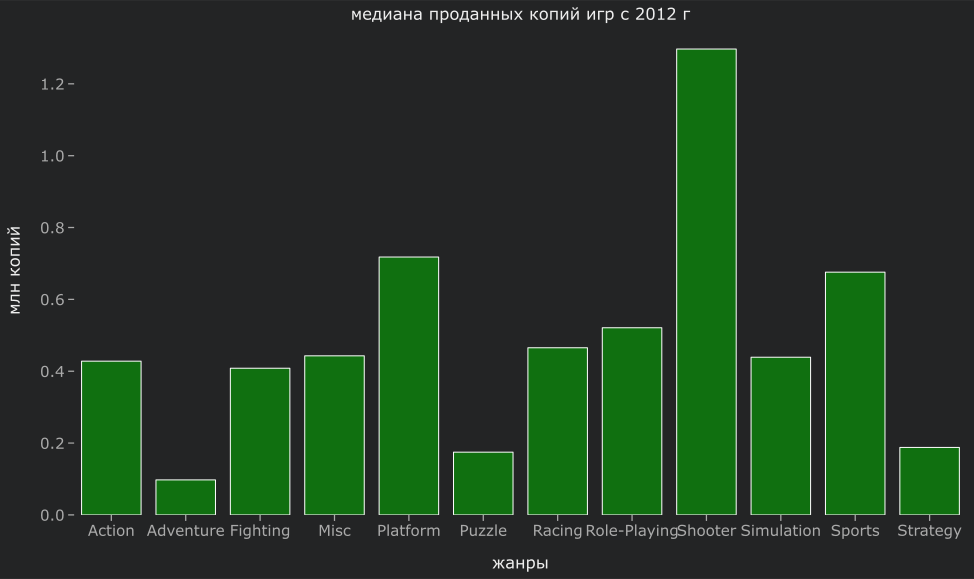

In [93]:
sns.barplot(data=games_genre,
            x='genre',
            y='sum_sales',
            color='green'
            ).set(
    title=f'медиана проданных копий игр с {analytic_start_year} г',
    xlabel='жанры',
    ylabel='млн копий',
)

 Что можно сказать о самых прибыльных жанрах?

- Shooter
- Platform
- Sports

Самые продаваемые с 2012 года. «Движ» — продаётся хорошо…

Выделяются ли жанры с высокими и низкими продажами?

А вот у
- Puzzle
- Strategy
- Adventure

Дела не так хорошо, самые низкие медианы продаж…

<hr>

## Шаг 4. Составьте портрет пользователя каждого региона

Посмотрим по регионам где какие жанры продаются лучше.

In [83]:

display(
    games_df.columns
)

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating',
       'sum_sales'],
      dtype='object')

### Продажи в Северной Америке `na_sales`

In [134]:
games_genre_na = games_df.loc[
    with_years
    & (games_df['year_of_release'] >= analytic_start_year),
    ['na_sales', 'genre']
]

In [135]:
games_genre_na = games_genre_na.groupby(by='genre').mean()
games_genre_na.reset_index(inplace=True)
games_genre_na.sort_values(by='na_sales', ascending=False, inplace=True)

all_na_sales = games_genre_na['na_sales'].sum()
games_genre_na['na_percentage'] = (
        (games_genre_na['na_sales'] / all_na_sales) * 100
    )
games_genre_na['na_percentage'] = games_genre_na['na_percentage'].round(decimals=2)
games_genre_na['na_sales'] = round(games_genre_na['na_sales'] * 1_000_000)
games_genre_na['na_sales'] = games_genre_na['na_sales'].astype('uint32')

In [137]:
display(
    games_genre_na.loc[: , ][0: 5]
)

,genre,na_sales,na_percentage
8,Shooter,616211,26.515625
10,Sports,304199,13.093750
4,Platform,298584,12.843750
3,Misc,198853,8.562500
2,Fighting,181519,7.808594


- Shooter
- Sports
- Platform
- Misc
- Fighting


Самые продаваемые жанры в Северной Америке с 2012 года. По медиане количества продаж копий игр.

### Продажи в Европе `eu_sales`

In [143]:
games_genre_eu = games_df.loc[
    with_years
    & (games_df['year_of_release'] >= analytic_start_year),
    ['eu_sales', 'genre']
]

In [144]:
games_genre_eu = games_genre_eu.groupby(by='genre').mean()
games_genre_eu.reset_index(inplace=True)
games_genre_eu.sort_values(by='eu_sales', ascending=False, inplace=True)

all_eu_sales = games_genre_eu['eu_sales'].sum()
games_genre_eu['eu_percentage'] = (
        (games_genre_eu['eu_sales'] / all_na_sales) * 100
)

games_genre_eu['eu_percentage'] = games_genre_eu['eu_percentage'].round(decimals=2)
games_genre_eu['eu_sales'] = round(games_genre_eu['eu_sales'] * 1_000_000)
games_genre_eu['eu_sales'] = games_genre_eu['eu_sales'].astype('uint32')

In [145]:
display(
    games_genre_eu.loc[: , ][0: 5]
)

,genre,eu_sales,eu_percentage
8,Shooter,482910,20.781250
10,Sports,257812,11.093750
4,Platform,251953,10.843750
6,Racing,237305,10.210938
9,Simulation,181885,7.820312


- Shooter
- Sports
- Platform
- Racing
- Simulation


Самые продаваемые жанры в Европе с 2012 года. По медиане количества продаж копий игр.

### Продажи в Японии `jp_sales`

In [146]:
games_genre_jp = games_df.loc[
    with_years
    & (games_df['year_of_release'] >= analytic_start_year),
    ['jp_sales', 'genre']
]

In [147]:
games_genre_jp = games_genre_jp.groupby(by='genre').mean()
games_genre_jp.reset_index(inplace=True)
games_genre_jp.sort_values(by='jp_sales', ascending=False, inplace=True)

all_jp_sales = games_genre_jp['jp_sales'].sum()
games_genre_jp['jp_percentage'] = (
        (games_genre_jp['jp_sales'] / all_na_sales) * 100
)

games_genre_jp['jp_percentage'] = games_genre_jp['jp_percentage'].round(decimals=2)
games_genre_jp['jp_sales'] = round(games_genre_jp['jp_sales'] * 1_000_000)
games_genre_jp['jp_sales'] = games_genre_jp['jp_sales'].astype('uint32')

In [148]:
display(
    games_genre_jp.loc[: , ][0: 5]
)

,genre,jp_sales,jp_percentage
7,Role-Playing,176880,7.609375
9,Simulation,130127,5.601562
4,Platform,101501,4.371094
2,Fighting,86609,3.730469
5,Puzzle,76416,3.289062


- Role-Playing
- Simulation
- Platform
- Fighting
- Puzzle


Самые продаваемые жанры в Японии с 2012 года. По медиане количества продаж копий игр.

### Продажи в других странах `other_sales`

In [151]:
games_genre_other = games_df.loc[
    with_years
    & (games_df['year_of_release'] >= analytic_start_year),
    ['other_sales', 'genre']
]

In [152]:
games_genre_other = games_genre_other.groupby(by='genre').mean()
games_genre_other.reset_index(inplace=True)
games_genre_other.sort_values(by='other_sales', ascending=False, inplace=True)

games_genre_other['other_sales'] = round(games_genre_other['other_sales'] * 1_000_000)
games_genre_other['other_sales'] = games_genre_other['other_sales'].astype('uint32')

display(
    games_genre_other
)

,genre,other_sales
8,Shooter,158569
10,Sports,83740
4,Platform,65674
6,Racing,56427
0,Action,49591
2,Fighting,41016
7,Role-Playing,40070
3,Misc,39948
9,Simulation,27374
11,Strategy,14931


- Shooter
- Sports
- Platform
- Racing
- Action


Самые продаваемые жанры в других локациях с 2012 года. Кроме Японии, Европы и Северной Америки. По медиане количества продаж копий игр.

<hr>

## Шаг 5. Проверьте гипотезы

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые?

$H_0: \mu_s = \mu_u$ — средние пользовательские рейтинги платформ Xbox One и PC <mark>одинаковая</mark>
$H_1: \mu_s \neq \mu_u$ — средние пользовательские рейтинги платформ Xbox One и PC <mark>различается</mark>

In [162]:
xone_score = games_df.loc[
    with_years
    & with_users_score_value
    & (games_df['year_of_release'] >= analytic_start_year)
    & (games_df['platform'] == 'XOne'),
    'user_score'
]

In [163]:
xone_score_dispersion = np.var(xone_score, ddof=1)

In [164]:
pc_score = games_df.loc[
    with_years
    & with_users_score_value
    & (games_df['year_of_release'] >= analytic_start_year)
    & (games_df['platform'] == 'PC'),
    'user_score'
]

In [165]:
pc_score_dispersion = np.var(pc_score, ddof=1)

In [166]:
display(
    xone_score.describe(),
    xone_score_dispersion
)

count    182.000000
mean       6.523438
std        1.380859
min        1.599609
25%        5.800781
50%        6.800781
75%        7.500000
max        9.203125
Name: user_score, dtype: float64

182

1.907

In [167]:
display(
    pc_score.describe(),
    pc_score_dispersion
)

count    206.000000
mean       6.425781
std        1.665039
min        1.400391
25%        5.500000
50%        6.800781
75%        7.699219
max        9.296875
Name: user_score, dtype: float64

206

2.771

In [168]:
print(round(pc_score_dispersion / xone_score_dispersion, 2))

1.45


Дисперсии различаются менее чем в 4 раза $1.45 < 4$, поэтому выбираем `equal_var=True`

$\alpha = 0.01$, критерий значимости
оставим только 1% для ошибки первого рода (отвергнуть нулевую гипотезу, когда она верна)

In [170]:
display(
    st.ttest_ind(
        a=xone_score,
        b=pc_score,
        equal_var = True
    )
)

Ttest_indResult(statistic=0.5990965631401651, pvalue=0.5494599345181355)

Отвергнуть $H_0$ не можем, потомучто $\alpha < pvalue, 0.01 < 0.55$.
То есть вероятность получить такие или ещё более выраженные отличия случайно 54,95%.
Продолжаем считать что в среднем оценки пользователей XOne и PC одинаковые…

### Средние пользовательские рейтинги жанров Action и Sports одинаковые?

$H_0: \mu_s = \mu_u$ — средние пользовательские рейтинги жанров Action и Sports <mark>одинаковая</mark>
$H_1: \mu_s \neq \mu_u$ — средние пользовательские рейтинги жанров Action и Sports <mark>различается</mark>

$\alpha = 0.01$, критерий значимости
оставим только 1% для ошибки первого рода (отвергнуть нулевую гипотезу, когда она верна)

In [179]:
action_score = games_df.loc[
    with_years
    & with_users_score_value
    & (games_df['year_of_release'] >= analytic_start_year)
    & (games_df['genre'] == 'Action'),
    'user_score'
]

In [180]:
action_score_dispersion = np.var(action_score, ddof=1)

In [181]:
sport_score = games_df.loc[
    with_years
    & with_users_score_value
    & (games_df['year_of_release'] >= analytic_start_year)
    & (games_df['genre'] == 'Sports'),
    'user_score'
]

In [182]:
sport_score_dispersion = np.var(sport_score, ddof=1)

In [183]:
display(
    action_score.describe(),
    action_score_dispersion
)

count    523.000000
mean       6.824219
std        1.374023
min        1.599609
25%        6.250000
50%        7.101562
75%        7.800781
max        9.101562
Name: user_score, dtype: float64

1.889

In [184]:
display(
    sport_score.describe(),
    sport_score_dispersion
)

count    195.000000
mean       5.457031
std        1.739258
min        0.199951
25%        4.300781
50%        5.699219
75%        6.800781
max        8.796875
Name: user_score, dtype: float64

3.023

In [185]:
print(round(sport_score_dispersion / action_score_dispersion, 2))

1.6


Дисперсии различаются менее чем в 4 раза $1.6 < 4$, поэтому выбираем `equal_var=True`

In [186]:
display(
    st.ttest_ind(
        a=action_score,
        b=sport_score,
        equal_var = True
    )
)

Ttest_indResult(statistic=10.995231087544438, pvalue=4.3011572883953764e-26)

Можем отвергнуть $H_0$ нулевую гипотезу и принять альтернативную, потомучто $\alpha > pvalue, 0.01 > 4.3 \times 10^{-26}$.
Считаем что в среднем оценки пользователей для жанров Action и Sport отличаются…

<hr>

## Шаг 6. Напишите общий вывод